In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from xgboost import plot_importance
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os, gc
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# pip install xgboost

In [3]:
train_data = pd.read_csv('E:\Lam Nhut Thinh\CV\Projects\Team\Attacker\\train_attacker_2022.csv', index_col="id", skipinitialspace = True)
test_data = pd.read_excel('E:\Lam Nhut Thinh\CV\Projects\Team\Attacker\\test_attacker_2022.xlsx', index_col="id", header=0)

C:\Users\Khang Lam\AppData\Local\Temp\ipykernel_14688\2764022008.py:1: DtypeWarning: Columns (42,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('E:\Lam Nhut Thinh\CV\Projects\Team\Attacker\\train_attacker_2022.csv', index_col="id", skipinitialspace = True)


Clean column names

In [4]:
for (columnName, columnData) in train_data.iteritems():
    train_data[columnName] = columnData.replace(['-   ', ' -   ', ' '], '')
    
for (columnName, columnData) in test_data.iteritems():
    test_data[columnName] = columnData.replace(['-   ', ' -   ', ' '], '')
    
train_data.columns = train_data.columns.str.replace(' ', '')
test_data.columns = test_data.columns.str.replace(' ', '')

C:\Users\Khang Lam\AppData\Local\Temp\ipykernel_14688\1930597659.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (columnName, columnData) in train_data.iteritems():
C:\Users\Khang Lam\AppData\Local\Temp\ipykernel_14688\1930597659.py:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (columnName, columnData) in test_data.iteritems():


In [5]:
print(train_data.info())
print(test_data.info())
gc.collect()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48030 entries, 11651 to 89883
Data columns (total 65 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   label                      48030 non-null  int64  
 1   time_1                     22991 non-null  object 
 2   time_2                     22991 non-null  object 
 3   Field_11                   6679 non-null   object 
 4   cat_1                      22991 non-null  object 
 5   cat_2                      22991 non-null  object 
 6   cat_3                      22991 non-null  float64
 7   cat_4                      6650 non-null   object 
 8   cat_5                      22991 non-null  float64
 9   date_1                     14139 non-null  object 
 10  mer_des                    7570 non-null   object 
 11  mul_rate                   22991 non-null  float64
 12  value                      22991 non-null  object 
 13  cat_6                      22991 non-null 

119

**Drop any columns with null values > 60%**

In [6]:
# X_train = X_train.drop(columns=["Field_11", "time_1", "time_2", "date_1", "date_2", "date_3", "date_4"], axis=1)
columns_to_drop = [col for col in train_data.columns if (train_data[col].isna().sum()/len(train_data[col]) > 0.6)]
train_data = train_data.drop(columns=columns_to_drop, axis=1)
test_data = test_data.drop(columns=columns_to_drop, axis=1)
test_data = test_data.drop(columns=["date_2", "date_3"], axis=1)
print(train_data.info())
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48030 entries, 11651 to 89883
Data columns (total 53 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   label                   48030 non-null  int64  
 1   time_1                  22991 non-null  object 
 2   time_2                  22991 non-null  object 
 3   cat_1                   22991 non-null  object 
 4   cat_2                   22991 non-null  object 
 5   cat_3                   22991 non-null  float64
 6   cat_5                   22991 non-null  float64
 7   mul_rate                22991 non-null  float64
 8   value                   22991 non-null  object 
 9   cat_6                   22991 non-null  float64
 10  num_date_review         22991 non-null  float64
 11  review_value            22991 non-null  object 
 12  date_2                  22446 non-null  object 
 13  date_3                  20894 non-null  object 
 14  dob                     22991 non-

In [7]:
# get list of categorical features
list_categorical_cols = list(train_data.columns[train_data.dtypes == 'O'])

categorical_cols_exceptions = ['value', 'review_value']

print(list_categorical_cols)
# get info about different categories
for cat_feature in list_categorical_cols:
    if train_data[cat_feature].value_counts().shape[0] > 4 and cat_feature not in categorical_cols_exceptions:
        train_data = train_data.drop(cat_feature, axis=1)
    else:
        print(train_data[cat_feature].value_counts())

list_categorical_cols_test = list(test_data.columns[test_data.dtypes == 'O'])
for cat_feature in list_categorical_cols_test:
    if test_data[cat_feature].value_counts().shape[0] > 4 and cat_feature not in categorical_cols_exceptions:
        test_data = test_data.drop(cat_feature, axis=1)
    else:
        print(test_data[cat_feature].value_counts())

['time_1', 'time_2', 'cat_1', 'cat_2', 'value', 'review_value', 'date_2', 'date_3', 'sex', 'address', 'location_id', 'mer_id', 'mer_name', 'trans_location', 'cat_8', 'job', 'cat_9', 'com_type', 'cat_12', 'unknown_var_5', 'social_sex_info', 'social_location_id']
C1    12406
C2    10585
Name: cat_1, dtype: int64
P2    12512
P1    10479
Name: cat_2, dtype: int64
1,490,000    1509
1,390,000    1235
4,500,000     665
973,000       497
1,043,000     433
             ... 
5,632,000       1
4,468,000       1
2,905,000       1
3,036,000       1
4,467,200       1
Name: value, Length: 4404, dtype: int64
             21019
1,150,000      205
1,210,000      130
3,317,000       76
3,745,000       67
             ...  
5,232,000        1
3,377,000        1
4,129,000        1
3,177,280        1
2,221,000        1
Name: review_value, Length: 583, dtype: int64
MALE      13149
FEMALE     9842
Name: sex, dtype: int64
male      12465
female     8593
Name: social_sex_info, dtype: int64
C1    1365
C2    1208

In [8]:
# print(f'job: {train_data.job.isnull().sum()}')
# print(f'address: {train_data.address.isnull().sum()}')
# print(f'trans_location: {train_data.trans_location.isnull().sum()}')
# print(f'com_type: {train_data.com_type.isnull().sum()}')
# columns_to_binary = ["job", "address", "trans_location", "com_type"]

# for col in columns_to_binary:
#     train_data[col] = train_data[col].apply(lambda x : 0 if x is None else 1)
#     print(f'{col}: {train_data[col].isnull().sum()}')

# train_data.info()

In [9]:
# subset_to_dropna = ["time_1", "time_2"]
# train_data = train_data.dropna(subset=subset_to_dropna)
# test_data = test_data.dropna(subset=subset_to_dropna)
# print(train_data.info())
# print(test_data.info())

In [10]:
# test_data = test_data.drop(columns=['date_2', 'date_3'], axis=1)

Clean data

In [11]:
gc.collect()

0

In [15]:
# train_data['age'] = train_data["dob"].apply(lambda x : (2022 - int(str(x)[:4])))

# train_data['complete_duration'] = pd.to_numeric(pd.to_datetime(train_data['time_2']) - pd.to_datetime(train_data['time_1']))
# train_data['time_1'] = pd.to_numeric(pd.to_datetime(train_data['time_1']))
# train_data['time_2'] = pd.to_numeric(pd.to_datetime(train_data['time_2']))
# train_data = train_data.drop(columns=['time_1', 'time_2'], axis=1)
# train_data['date_1'] = pd.to_numeric(pd.to_datetime(train_data['date_1']))
# train_data['date_2'] = pd.to_numeric(pd.to_datetime(train_data['date_2']))
# train_data['date_3'] = pd.to_numeric(pd.to_datetime(train_data['date_3']))
# train_data['date_4'] = pd.to_numeric(pd.to_datetime(train_data['date_4']))
train_data['value'] = pd.to_numeric(train_data['value'].str.replace(',', ''))
train_data['review_value'] = pd.to_numeric(train_data['review_value'].str.replace(',', ''))



In [17]:
# test_data['age'] = test_data["dob"].apply(lambda x : (2022 - int(str(x)[:4])))

# test_data['complete_duration'] = pd.to_numeric(pd.to_datetime(test_data['time_2']) - pd.to_datetime(test_data['time_1']))
# test_data['time_1'] = pd.to_numeric(pd.to_datetime(test_data['time_1']))
# test_data['time_2'] = pd.to_numeric(pd.to_datetime(test_data['time_2']))
# test_data = test_data.drop(columns=['time_1', 'time_2'], axis=1)

# test_data['value'] = pd.to_numeric(test_data['value'].str.replace(',', ''))
# test_data['review_value'] = pd.to_numeric(test_data['review_value'].str.replace(',', ''))

In [18]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 31502 to 75660
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cat_1                   2573 non-null   object 
 1   cat_2                   2573 non-null   object 
 2   cat_3                   2573 non-null   float64
 3   cat_5                   2573 non-null   float64
 4   mul_rate                2573 non-null   float64
 5   value                   2573 non-null   float64
 6   cat_6                   2573 non-null   float64
 7   num_date_review         2573 non-null   float64
 8   review_value            2573 non-null   float64
 9   dob                     2573 non-null   float64
 10  sex                     2573 non-null   object 
 11  cat_7                   2573 non-null   float64
 12  num_trans_last_month    2573 non-null   float64
 13  cat_10                  2573 non-null   float64
 14  cat_11                  2573 non-nu

In [19]:
new_train = train_data.groupby(train_data.index).first()

cols = list(train_data.columns) 
train_data.loc[train_data.index.isin(new_train.index), cols] = new_train[cols]

new_test = test_data.groupby(test_data.index).first()

cols = list(test_data.columns) 
test_data.loc[test_data.index.isin(new_test.index), cols] = new_test[cols]

In [20]:
def imputer(df):
    median = SimpleImputer(missing_values=np.nan,strategy='median')
    mode = SimpleImputer(missing_values=np.nan,strategy='most_frequent')
    for col in df.columns:    
        if df[col].isnull().any()==True:
            if df[col].dtypes=='O':
#                 df[col]=mode.fit_transform(df[[col]])
                df[col] = df[col].apply(lambda x: col + '_No' if x is None else x)
            else:
                df[col]=mode.fit_transform(df[[col]])   
    return df

In [21]:
gc.collect()
print(imputer(train_data))
print(imputer(test_data))

       label     cat_1     cat_2  cat_3  cat_5  mul_rate      value  cat_6  \
id                                                                           
11651      0        C1        P2    1.0    1.0      0.00  4357542.0    1.0   
48491      0        C2        P1    1.0    1.0      0.00  4480000.0    1.0   
42868      0        C2        P1    1.0    1.0      2.26  3367400.0    1.0   
68835      1        C2        P1    1.0    1.0      0.00  4260000.0    1.0   
73688      1  cat_1_No  cat_2_No    1.0    1.0      0.00  1490000.0    1.0   
...      ...       ...       ...    ...    ...       ...        ...    ...   
89571      0        C1        P2    1.0    1.0      0.00  4467200.0    1.0   
89621      0        C2        P1    1.0    1.0      0.00  4164000.0    1.0   
89649      0  cat_1_No  cat_2_No    1.0    1.0      0.00  1490000.0    1.0   
89826      1  cat_1_No  cat_2_No    1.0    1.0      0.00  1490000.0    1.0   
89883      0        C2        P1    1.0    1.0      0.00  500000

In [22]:
# train_data["cat_1"] = train_data["cat_1"].replace({ 'C1': 0, 'C2': 1})
# train_data["cat_2"] = train_data["cat_2"].replace({ 'P1': 0, 'P2': 1})

# train_data["social_sex_info"] = train_data["social_sex_info"].replace({ 'male': 0, 'female': 1})
# train_data["sex"] = train_data["sex"].replace({ 'MALE': 0, 'FEMALE': 1})

# train_data = pd.get_dummies(train_data)
# train_data.info()
# one_hot = pd.get_dummies(train_data['cat_4'])
# # Drop column cat_4 as it is now encoded
# train_data = train_data.drop('cat_4',axis = 1)
# # Join the encoded df
# train_data = train_data.join(one_hot)

In [23]:
# print(train_data['cat_1'].value_counts())
# print(train_data['cat_2'].value_counts())
# print(train_data['sex'].value_counts())
# print(train_data['social_sex_info'].value_counts())

In [24]:
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)

In [25]:
print(train_data.info())
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48030 entries, 11651 to 89883
Data columns (total 45 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   label                               48030 non-null  int64  
 1   cat_3                               48030 non-null  float64
 2   cat_5                               48030 non-null  float64
 3   mul_rate                            48030 non-null  float64
 4   value                               48030 non-null  float64
 5   cat_6                               48030 non-null  float64
 6   num_date_review                     48030 non-null  float64
 7   review_value                        48030 non-null  float64
 8   dob                                 48030 non-null  float64
 9   cat_7                               48030 non-null  float64
 10  num_trans_last_month                48030 non-null  float64
 11  cat_10                              4

In [26]:
X_train, y_train = train_data.drop(["label"], axis=1), train_data["label"]
gc.collect()

0

In [30]:
clf = XGBClassifier(n_estimators=100)
clf = clf.fit(X_train, y_train)

<Figure size 4000x800 with 0 Axes>

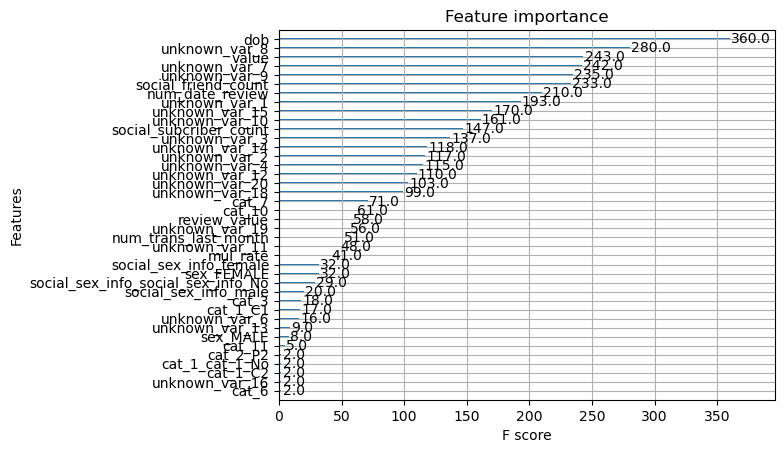

In [31]:
plt.figure(figsize=(40,8))
plot_importance(clf)
plt.show()

https://stackoverflow.com/questions/23307301/replacing-column-values-in-a-pandas-dataframe
https://stackoverflow.com/questions/48075861/valueerror-could-not-convert-string-to-float
https://stackoverflow.com/questions/41256626/pandas-typeerror-float-argument-must-be-a-string-or-a-number
https://towardsdatascience.com/understanding-feature-importance-and-how-to-implement-it-in-python-ff0287b20285
https://github.com/aabdygaziev/capstone-project/blob/master/work%20folder/cleaning.ipynb

In [33]:
train_data

,label,cat_3,cat_5,mul_rate,value,cat_6,num_date_review,review_value,dob,cat_7,...,cat_1_cat_1_No,cat_2_P1,cat_2_P2,cat_2_cat_2_No,sex_FEMALE,sex_MALE,sex_sex_No,social_sex_info_female,social_sex_info_male,social_sex_info_social_sex_info_No
id,,,,,,,,,,,,,,,,,,,,,
11651,0,1.0,1.0,0.00,4357542.0,1.0,0.0,1150000.0,19821122.0,0.0,...,0,0,1,0,0,1,0,0,1,0
48491,0,1.0,1.0,0.00,4480000.0,1.0,3.0,1150000.0,19930819.0,0.0,...,0,1,0,0,0,1,0,1,0,0
42868,0,1.0,1.0,2.26,3367400.0,1.0,0.0,1150000.0,19810807.0,1.0,...,0,1,0,0,1,0,0,1,0,0
68835,1,1.0,1.0,0.00,4260000.0,1.0,82.0,1150000.0,19800416.0,0.0,...,0,1,0,0,1,0,0,0,1,0
73688,1,1.0,1.0,0.00,1490000.0,1.0,0.0,1150000.0,19900101.0,0.0,...,1,0,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89571,0,1.0,1.0,0.00,4467200.0,1.0,51.0,1150000.0,19850507.0,4.0,...,0,0,1,0,1,0,0,0,1,0
89621,0,1.0,1.0,0.00,4164000.0,1.0,2.0,1150000.0,19900909.0,4.0,...,0,1,0,0,0,1,0,1,0,0
89649,0,1.0,1.0,0.00,1490000.0,1.0,0.0,1150000.0,19900101.0,0.0,...,1,0,0,1,0,0,1,0,1,0


In [34]:
test_data

,cat_3,cat_5,mul_rate,value,cat_6,num_date_review,review_value,dob,cat_7,num_trans_last_month,...,cat_1_cat_1_No,cat_2_P1,cat_2_P2,cat_2_cat_2_No,sex_FEMALE,sex_MALE,sex_sex_No,social_sex_info_female,social_sex_info_male,social_sex_info_social_sex_info_No
id,,,,,,,,,,,,,,,,,,,,,
31502,1.0,1.0,0.0,1490000.0,1.0,0.0,0.0,19810101.0,0.0,5.0,...,1,0,0,1,0,0,1,0,0,1
52725,1.0,1.0,0.0,973000.0,1.0,0.0,0.0,19741007.0,0.0,33.0,...,0,0,1,0,1,0,0,0,0,1
31752,1.0,1.0,0.0,3034000.0,1.0,0.0,3034000.0,19981101.0,4.0,5.0,...,0,0,1,0,0,1,0,0,0,1
78992,1.0,1.0,0.0,3250000.0,1.0,46.0,0.0,19810929.0,4.0,4.0,...,0,0,1,0,1,0,0,0,0,1
52965,1.0,1.0,0.0,3970000.0,1.0,0.0,0.0,19941028.0,1.0,4.0,...,0,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39570,1.0,1.0,0.0,1490000.0,1.0,0.0,0.0,19810101.0,0.0,5.0,...,1,0,0,1,0,0,1,0,0,1
47850,1.0,1.0,0.0,1490000.0,1.0,0.0,0.0,19810101.0,0.0,5.0,...,1,0,0,1,0,0,1,0,0,1
27093,1.0,1.0,0.0,2515000.0,1.0,0.0,2515000.0,19851130.0,1.0,5.0,...,0,1,0,0,0,1,0,0,0,1
